# Environment preparation and dataset split

In [4]:
#!pip install tensorflow_datasets
#!pip install inspect
#!pip install tqdm
#!pip install tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
import os
import numpy as np
import shutil
import pandas as pd
import datetime


Split data into train, val and test set

In [16]:
now = "/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
def train_test_split():
    print("########### Train Test Val Script started ###########")
    #data_csv = pd.read_csv("DataSet_Final.csv") ##Use if you have classes saved in any .csv file

    root_dir = 'C:/Users/matth/switchdrive/HSLU Master/3. sem/Deep Learning in Vision/Project/original_dataset_2'
    classes_dir = ['No Defect', 'Defect']

    processed_dir = "C:/Users/matth/switchdrive/HSLU Master/3. sem/Deep Learning in Vision/Project/original_dataset_2/Data_not_split"

    val_ratio = 0.10
    test_ratio = 0.10
    os.makedirs(root_dir + now)

    for cls in classes_dir:
        # Creating partitions of the data after shuffeling
        print("$$$$$$$ Class Name " + cls + " $$$$$$$")
        src = processed_dir +"/" + cls  # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])

        train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
        val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

        print('Total images: '+ str(len(allFileNames)))
        print('Training: '+ str(len(train_FileNames)))
        print('Validation: '+  str(len(val_FileNames)))
        print('Testing: '+ str(len(test_FileNames)))

        # # Creating Train / Val / Test folders (One time use)
        os.makedirs(root_dir + now +'/train/' + cls)
        os.makedirs(root_dir + now +'/val/' + cls)
        os.makedirs(root_dir + now +'/test/' + cls)

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + now +'/train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, root_dir + now +'/val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, root_dir + now +'/test/' + cls)

    print("########### Train Test Val Script Ended ###########")

train_test_split()

########### Train Test Val Script started ###########
$$$$$$$ Class Name No Defect $$$$$$$
Total images: 1840
Training: 1472
Validation: 184
Testing: 184
$$$$$$$ Class Name Defect $$$$$$$
Total images: 1177
Training: 941
Validation: 118
Testing: 118
########### Train Test Val Script Ended ###########


# Load all CNN's and compare them

In [17]:
# List all available models
""" Notes:
  See for example:
    https://arxiv.org/pdf/1810.00736.pdf
    https://colab.research.google.com/github/stephenleo/keras-model-selection/blob/main/keras_model_selection.ipynb#scrollTo=cfO_kZWhy6E3
    https://gist.github.com/stephenleo/8874556c221fa7ed5839c86aaecaa495
    https://www.kaggle.com/kriyeng/evaluate-26-pretrained-models-to-split-the-problem
    https://github.com/cgnorthcutt/benchmarking-keras-pytorch

"""
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary["MobileNetV2"]

<function keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>

load the training and validation data from directory and for both needed formats, i.e. 224,224,3 or 331,331,3

In [18]:
PATH = "C:/Users/matth/switchdrive/HSLU Master/3. sem/Deep Learning in Vision/Project/original_dataset_2" + now + "/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train224 = tf.keras.utils.image_dataset_from_directory(
    train_dir
    , labels="inferred", label_mode = "categorical"
    , class_names = ["Defect","No Defect"], color_mode = "rgb"
    , image_size = (224,224))

train331 = tf.keras.utils.image_dataset_from_directory(
    traindir
    , labels="inferred", label_mode = "categorical"
    , class_names = ["Defect","No Defect"], color_mode = "rgb"
    , image_size = (331,331))

val331 = tf.keras.utils.image_dataset_from_directory(
    validation_dir
    , labels="inferred", label_mode = "categorical"
    , class_names = ["Defect","No Defect"], color_mode = "rgb"
    , image_size = (331,331))

val224 = tf.keras.utils.image_dataset_from_directory(
    validation_dir
    , labels="inferred", label_mode = "categorical"
    , class_names = ["Defect","No Defect"], color_mode = "rgb"
    , image_size = (224,224))


Found 2413 files belonging to 2 classes.
Found 2413 files belonging to 2 classes.
Found 302 files belonging to 2 classes.
Found 302 files belonging to 2 classes.


In [ ]:
!pip uninstall h5py
!pip install h5py<'3.0.0'

Train all CNN, only one dense layer with softmax activation function is trained

In [19]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

num_classes = 2
num_iterations = 16

for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train331
        validation_processed = val331
    else:
        input_shape=(224,224,3)
        train_processed = train224
        validation_processed = val224
        
    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False
    
    # custom modifications on top of pre-trained model and fit
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed, steps_per_epoch=num_iterations)
    
    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])


  0%|                                                                                           | 0/28 [00:00<?, ?it/s]

Epoch 1/3
16/16 [==============================] - 101s 5s/step - loss: 10.3066 - accuracy: 0.6309 - val_loss: 2.3422 - val_accuracy: 0.6060
Epoch 2/3
16/16 [==============================] - 80s 5s/step - loss: 2.7224 - accuracy: 0.6289 - val_loss: 1.8697 - val_accuracy: 0.6755
Epoch 3/3
16/16 [==============================] - 80s 5s/step - loss: 2.3175 - accuracy: 0.6602 - val_loss: 1.3017 - val_accuracy: 0.7086



  4%|██▊                                                                             | 1/28 [04:29<2:01:25, 269.84s/it]

Epoch 1/3
16/16 [==============================] - 127s 7s/step - loss: 8.8107 - accuracy: 0.5508 - val_loss: 1.0146 - val_accuracy: 0.7152
Epoch 2/3
16/16 [==============================] - 87s 6s/step - loss: 4.0079 - accuracy: 0.6328 - val_loss: 3.8739 - val_accuracy: 0.6821
Epoch 3/3
16/16 [==============================] - 86s 6s/step - loss: 4.9593 - accuracy: 0.6270 - val_loss: 1.9307 - val_accuracy: 0.6656



  7%|█████▋                                                                          | 2/28 [09:43<2:08:01, 295.44s/it]

Epoch 1/3
16/16 [==============================] - 119s 7s/step - loss: 3.7274 - accuracy: 0.5312 - val_loss: 0.8728 - val_accuracy: 0.7086
Epoch 2/3
16/16 [==============================] - 103s 7s/step - loss: 2.1792 - accuracy: 0.6289 - val_loss: 2.4624 - val_accuracy: 0.5430
Epoch 3/3
16/16 [==============================] - 105s 7s/step - loss: 1.6681 - accuracy: 0.6348 - val_loss: 1.8800 - val_accuracy: 0.6192



 11%|████████▌                                                                       | 3/28 [15:19<2:10:50, 314.04s/it]

Epoch 1/3
16/16 [==============================] - 43s 2s/step - loss: 0.6245 - accuracy: 0.6660 - val_loss: 0.5346 - val_accuracy: 0.7881
Epoch 2/3
16/16 [==============================] - 35s 2s/step - loss: 0.4948 - accuracy: 0.7969 - val_loss: 0.4472 - val_accuracy: 0.8411
Epoch 3/3
16/16 [==============================] - 35s 2s/step - loss: 0.4599 - accuracy: 0.8203 - val_loss: 0.4096 - val_accuracy: 0.8377



 14%|███████████▍                                                                    | 4/28 [17:16<1:34:28, 236.17s/it]

Epoch 1/3
16/16 [==============================] - 60s 3s/step - loss: 0.5622 - accuracy: 0.7480 - val_loss: 0.4500 - val_accuracy: 0.8444
Epoch 2/3
16/16 [==============================] - 49s 3s/step - loss: 0.4720 - accuracy: 0.8047 - val_loss: 0.3974 - val_accuracy: 0.8510
Epoch 3/3
16/16 [==============================] - 48s 3s/step - loss: 0.4095 - accuracy: 0.8281 - val_loss: 0.3715 - val_accuracy: 0.8642



 18%|██████████████▎                                                                 | 5/28 [19:56<1:20:00, 208.70s/it]

Epoch 1/3
16/16 [==============================] - 63s 3s/step - loss: 0.5882 - accuracy: 0.6875 - val_loss: 0.4853 - val_accuracy: 0.7815
Epoch 2/3
16/16 [==============================] - 50s 3s/step - loss: 0.4868 - accuracy: 0.7832 - val_loss: 0.4307 - val_accuracy: 0.8179
Epoch 3/3
16/16 [==============================] - 51s 3s/step - loss: 0.4284 - accuracy: 0.8086 - val_loss: 0.3969 - val_accuracy: 0.8510



 21%|█████████████████▏                                                              | 6/28 [22:43<1:11:21, 194.60s/it]

Epoch 1/3
16/16 [==============================] - 81s 4s/step - loss: 0.6060 - accuracy: 0.6777 - val_loss: 0.4882 - val_accuracy: 0.7748
Epoch 2/3
16/16 [==============================] - 68s 4s/step - loss: 0.4576 - accuracy: 0.8301 - val_loss: 0.4063 - val_accuracy: 0.8510
Epoch 3/3
16/16 [==============================] - 67s 4s/step - loss: 0.3976 - accuracy: 0.8535 - val_loss: 0.3919 - val_accuracy: 0.8311



 25%|████████████████████                                                            | 7/28 [26:23<1:11:02, 202.97s/it]

Epoch 1/3
16/16 [==============================] - 110s 6s/step - loss: 0.5990 - accuracy: 0.6699 - val_loss: 0.5138 - val_accuracy: 0.8113
Epoch 2/3
16/16 [==============================] - 92s 6s/step - loss: 0.5037 - accuracy: 0.7832 - val_loss: 0.4725 - val_accuracy: 0.8079
Epoch 3/3
16/16 [==============================] - 85s 5s/step - loss: 0.4678 - accuracy: 0.7910 - val_loss: 0.4230 - val_accuracy: 0.8311



 29%|██████████████████████▊                                                         | 8/28 [31:16<1:17:14, 231.73s/it]

Epoch 1/3
16/16 [==============================] - 146s 9s/step - loss: 0.5934 - accuracy: 0.6602 - val_loss: 0.5208 - val_accuracy: 0.7881
Epoch 2/3
16/16 [==============================] - 134s 9s/step - loss: 0.5364 - accuracy: 0.7539 - val_loss: 0.4616 - val_accuracy: 0.8411
Epoch 3/3
16/16 [==============================] - 136s 9s/step - loss: 0.4912 - accuracy: 0.7910 - val_loss: 0.4359 - val_accuracy: 0.8543



 32%|█████████████████████████▋                                                      | 9/28 [38:19<1:32:13, 291.25s/it]

Epoch 1/3
16/16 [==============================] - 207s 12s/step - loss: 0.6597 - accuracy: 0.5996 - val_loss: 0.5938 - val_accuracy: 0.6722
Epoch 2/3
16/16 [==============================] - 186s 12s/step - loss: 0.5826 - accuracy: 0.6914 - val_loss: 0.5579 - val_accuracy: 0.7682
Epoch 3/3
16/16 [==============================] - 189s 12s/step - loss: 0.5483 - accuracy: 0.7539 - val_loss: 0.5078 - val_accuracy: 0.8146



 36%|████████████████████████████▏                                                  | 10/28 [48:09<1:55:07, 383.74s/it]

Epoch 1/3
16/16 [==============================] - 285s 17s/step - loss: 0.6253 - accuracy: 0.6270 - val_loss: 0.5304 - val_accuracy: 0.7252
Epoch 2/3
16/16 [==============================] - 256s 16s/step - loss: 0.5600 - accuracy: 0.7031 - val_loss: 0.4892 - val_accuracy: 0.8013
Epoch 3/3
16/16 [==============================] - 239s 15s/step - loss: 0.4957 - accuracy: 0.7578 - val_loss: 0.4454 - val_accuracy: 0.8212



 39%|██████████████████████████████▎                                              | 11/28 [1:01:20<2:24:00, 508.29s/it]

Epoch 1/3
16/16 [==============================] - 228s 14s/step - loss: 1359.4968 - accuracy: 0.5234 - val_loss: 219.1194 - val_accuracy: 0.6093
Epoch 2/3
16/16 [==============================] - 205s 13s/step - loss: 817.6087 - accuracy: 0.5254 - val_loss: 527.3320 - val_accuracy: 0.6093
Epoch 3/3
16/16 [==============================] - 214s 14s/step - loss: 742.8871 - accuracy: 0.5508 - val_loss: 80.1405 - val_accuracy: 0.6225



 43%|█████████████████████████████████                                            | 12/28 [1:12:16<2:27:30, 553.16s/it]

Epoch 1/3
16/16 [==============================] - 117s 7s/step - loss: 5.1908 - accuracy: 0.5996 - val_loss: 4.2728 - val_accuracy: 0.6093
Epoch 2/3
16/16 [==============================] - 107s 7s/step - loss: 2.5744 - accuracy: 0.6699 - val_loss: 3.7741 - val_accuracy: 0.6325
Epoch 3/3
16/16 [==============================] - 100s 6s/step - loss: 2.6586 - accuracy: 0.6797 - val_loss: 1.0819 - val_accuracy: 0.7748



 46%|███████████████████████████████████▊                                         | 13/28 [1:17:43<2:01:11, 484.77s/it]

Epoch 1/3
16/16 [==============================] - 23s 1s/step - loss: 0.6149 - accuracy: 0.6621 - val_loss: 0.5257 - val_accuracy: 0.7219
Epoch 2/3
16/16 [==============================] - 21s 1s/step - loss: 0.5369 - accuracy: 0.7090 - val_loss: 0.4714 - val_accuracy: 0.7715
Epoch 3/3
16/16 [==============================] - 22s 1s/step - loss: 0.4989 - accuracy: 0.7324 - val_loss: 0.4412 - val_accuracy: 0.7881



 50%|██████████████████████████████████████▌                                      | 14/28 [1:18:50<1:23:38, 358.50s/it]

Epoch 1/3
16/16 [==============================] - 25s 1s/step - loss: 0.6432 - accuracy: 0.6719 - val_loss: 0.5176 - val_accuracy: 0.7119
Epoch 2/3
16/16 [==============================] - 19s 1s/step - loss: 0.4954 - accuracy: 0.7480 - val_loss: 0.4606 - val_accuracy: 0.7517
Epoch 3/3
16/16 [==============================] - 19s 1s/step - loss: 0.4557 - accuracy: 0.7754 - val_loss: 0.3934 - val_accuracy: 0.8311



 54%|██████████████████████████████████████████▎                                    | 15/28 [1:19:55<58:31, 270.11s/it]

Epoch 1/3
16/16 [==============================] - 24s 1s/step - loss: 0.5392 - accuracy: 0.7344 - val_loss: 0.4166 - val_accuracy: 0.7980
Epoch 2/3
16/16 [==============================] - 19s 1s/step - loss: 0.3979 - accuracy: 0.8242 - val_loss: 0.3391 - val_accuracy: 0.8576
Epoch 3/3
16/16 [==============================] - 19s 1s/step - loss: 0.3273 - accuracy: 0.8691 - val_loss: 0.2981 - val_accuracy: 0.8940



 57%|█████████████████████████████████████████████▏                                 | 16/28 [1:20:59<41:34, 207.88s/it]

Epoch 1/3
16/16 [==============================] - 14s 630ms/step - loss: 0.5412 - accuracy: 0.7266 - val_loss: 0.4321 - val_accuracy: 0.8278
Epoch 2/3
16/16 [==============================] - 9s 586ms/step - loss: 0.4471 - accuracy: 0.7910 - val_loss: 0.3671 - val_accuracy: 0.8642
Epoch 3/3
16/16 [==============================] - 9s 589ms/step - loss: 0.3722 - accuracy: 0.8535 - val_loss: 0.3492 - val_accuracy: 0.8609



 61%|███████████████████████████████████████████████▉                               | 17/28 [1:21:32<28:30, 155.46s/it]

Epoch 1/3
16/16 [==============================] - 533s 33s/step - loss: 0.7741 - accuracy: 0.5723 - val_loss: 0.5447 - val_accuracy: 0.6954
Epoch 2/3
16/16 [==============================] - 499s 32s/step - loss: 0.5589 - accuracy: 0.6875 - val_loss: 0.5174 - val_accuracy: 0.6921
Epoch 3/3
16/16 [==============================] - 502s 32s/step - loss: 0.5422 - accuracy: 0.6973 - val_loss: 0.4678 - val_accuracy: 0.7517



 64%|█████████████████████████████████████████████████▌                           | 18/28 [1:47:17<1:35:30, 573.02s/it]

Epoch 1/3
16/16 [==============================] - 52s 2s/step - loss: 1.0526 - accuracy: 0.5449 - val_loss: 0.6062 - val_accuracy: 0.6159
Epoch 2/3
16/16 [==============================] - 36s 2s/step - loss: 0.6490 - accuracy: 0.6406 - val_loss: 0.8469 - val_accuracy: 0.5993
Epoch 3/3
16/16 [==============================] - 35s 2s/step - loss: 0.6252 - accuracy: 0.6582 - val_loss: 0.5400 - val_accuracy: 0.7219



 68%|████████████████████████████████████████████████████▎                        | 19/28 [1:49:27<1:05:58, 439.84s/it]

Epoch 1/3
16/16 [==============================] - 275s 17s/step - loss: 0.5581 - accuracy: 0.7578 - val_loss: 0.4157 - val_accuracy: 0.8278
Epoch 2/3
16/16 [==============================] - 262s 17s/step - loss: 0.4349 - accuracy: 0.8008 - val_loss: 0.3431 - val_accuracy: 0.8278
Epoch 3/3
16/16 [==============================] - 263s 17s/step - loss: 0.3364 - accuracy: 0.8574 - val_loss: 0.2952 - val_accuracy: 0.8609



 71%|███████████████████████████████████████████████████████                      | 20/28 [2:02:51<1:13:13, 549.14s/it]

Epoch 1/3
16/16 [==============================] - 229s 14s/step - loss: 39.1765 - accuracy: 0.4766 - val_loss: 6.4934 - val_accuracy: 0.5497
Epoch 2/3
16/16 [==============================] - 217s 14s/step - loss: 18.6788 - accuracy: 0.5469 - val_loss: 39.0619 - val_accuracy: 0.6093
Epoch 3/3
16/16 [==============================] - 216s 14s/step - loss: 19.0970 - accuracy: 0.5723 - val_loss: 38.1111 - val_accuracy: 0.3907



 75%|█████████████████████████████████████████████████████████▊                   | 21/28 [2:13:56<1:08:08, 584.09s/it]

Epoch 1/3
16/16 [==============================] - 330s 20s/step - loss: 0.5780 - accuracy: 0.6875 - val_loss: 0.3619 - val_accuracy: 0.8742
Epoch 2/3
16/16 [==============================] - 303s 19s/step - loss: 0.3900 - accuracy: 0.8281 - val_loss: 0.3231 - val_accuracy: 0.8940
Epoch 3/3
16/16 [==============================] - 308s 20s/step - loss: 0.2970 - accuracy: 0.8809 - val_loss: 0.2877 - val_accuracy: 0.9073



 79%|████████████████████████████████████████████████████████████▌                | 22/28 [2:29:42<1:09:16, 692.69s/it]

Epoch 1/3
16/16 [==============================] - 292s 18s/step - loss: 106.8740 - accuracy: 0.5723 - val_loss: 128.6174 - val_accuracy: 0.6093
Epoch 2/3
16/16 [==============================] - 273s 17s/step - loss: 79.7602 - accuracy: 0.5332 - val_loss: 139.3767 - val_accuracy: 0.3907
Epoch 3/3
16/16 [==============================] - 273s 18s/step - loss: 71.0595 - accuracy: 0.5547 - val_loss: 4.4545 - val_accuracy: 0.7351



 82%|███████████████████████████████████████████████████████████████▎             | 23/28 [2:43:46<1:01:30, 738.11s/it]

Epoch 1/3
16/16 [==============================] - 104s 6s/step - loss: 0.5615 - accuracy: 0.7402 - val_loss: 0.4156 - val_accuracy: 0.8278
Epoch 2/3
16/16 [==============================] - 98s 6s/step - loss: 0.3930 - accuracy: 0.8301 - val_loss: 0.3726 - val_accuracy: 0.8477
Epoch 3/3
16/16 [==============================] - 97s 6s/step - loss: 0.3528 - accuracy: 0.8438 - val_loss: 0.3218 - val_accuracy: 0.8709



 86%|███████████████████████████████████████████████████████████████████▋           | 24/28 [2:48:48<40:28, 607.08s/it]

Epoch 1/3
16/16 [==============================] - 107s 7s/step - loss: 21.2931 - accuracy: 0.5938 - val_loss: 6.2706 - val_accuracy: 0.6589
Epoch 2/3
16/16 [==============================] - 100s 6s/step - loss: 12.7311 - accuracy: 0.5977 - val_loss: 8.6745 - val_accuracy: 0.6192
Epoch 3/3
16/16 [==============================] - 98s 6s/step - loss: 9.9344 - accuracy: 0.6309 - val_loss: 12.2098 - val_accuracy: 0.6093



 89%|██████████████████████████████████████████████████████████████████████▌        | 25/28 [2:53:55<25:51, 517.07s/it]

Epoch 1/3
16/16 [==============================] - 399s 25s/step - loss: 1.1569 - accuracy: 0.6074 - val_loss: 0.7935 - val_accuracy: 0.6589
Epoch 2/3
16/16 [==============================] - 397s 25s/step - loss: 0.7523 - accuracy: 0.6934 - val_loss: 0.5570 - val_accuracy: 0.7483
Epoch 3/3
16/16 [==============================] - 395s 25s/step - loss: 0.5981 - accuracy: 0.7441 - val_loss: 0.4604 - val_accuracy: 0.8046



 93%|█████████████████████████████████████████████████████████████████████████▎     | 26/28 [3:13:48<23:59, 719.86s/it]

Epoch 1/3
16/16 [==============================] - 473s 30s/step - loss: 0.8816 - accuracy: 0.6348 - val_loss: 0.5329 - val_accuracy: 0.7715
Epoch 2/3
16/16 [==============================] - 474s 30s/step - loss: 0.5047 - accuracy: 0.7734 - val_loss: 0.4181 - val_accuracy: 0.8444
Epoch 3/3
16/16 [==============================] - 471s 30s/step - loss: 0.4531 - accuracy: 0.8340 - val_loss: 0.3552 - val_accuracy: 0.8543



 96%|████████████████████████████████████████████████████████████████████████████▏  | 27/28 [3:37:27<15:29, 929.55s/it]

Epoch 1/3
16/16 [==============================] - 79s 5s/step - loss: 11.4781 - accuracy: 0.6484 - val_loss: 8.9141 - val_accuracy: 0.6225
Epoch 2/3
16/16 [==============================] - 76s 5s/step - loss: 6.7654 - accuracy: 0.6602 - val_loss: 2.4702 - val_accuracy: 0.7517
Epoch 3/3
16/16 [==============================] - 75s 5s/step - loss: 6.2756 - accuracy: 0.6602 - val_loss: 3.0216 - val_accuracy: 0.7616


100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [3:41:18<00:00, 474.24s/it]


In [20]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
benchmark_df.sort_values('num_model_params', inplace=True)

# write results to csv file
benchmark_df.to_csv('benchmark_infrared2.csv', index=False)
benchmark_df

,model_name,num_model_params,validation_accuracy
16,MobileNetV3Small,1529968,0.860927
14,MobileNetV2,2257984,0.831126
13,MobileNet,3228864,0.788079
3,EfficientNetB0,4049571,0.837748
15,MobileNetV3Large,4226432,0.894040
18,NASNetMobile,4269716,0.721854
4,EfficientNetB1,6575239,0.864238
0,DenseNet121,7037504,0.708609
5,EfficientNetB2,7768569,0.850993
6,EfficientNetB3,10783535,0.831126


## graphical comparison of CNN's 

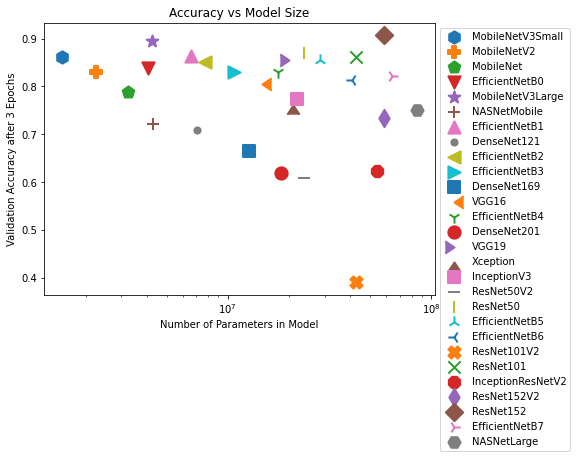

In [25]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))

for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');